In [1]:
import pandas as pd
import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score
sns.set()
%matplotlib inline

In [2]:
file_path = '../data/raw/Telco-Customer-Churn.csv'

# Read the CSV file into a DataFrame
df_raw = pd.read_csv(file_path)

# Display the first few rows of the DataFrame to verify it was read correctly
df_raw.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [3]:
def clean_data(df):
    df.rename(columns={'gender':'Gender'
                       ,'customerID':'CustomerID'
                       ,'Contract':'ContractType'
                       ,'InternetService':'InternetServiceType'
                       ,'tenure':'Tenure'
                      }
              ,inplace=True)


    df['Partner'] = df.Partner.map({'Yes':1,'No':0})
    df['Dependents'] = df.Dependents.map({'Yes':1,'No':0})

    df['PhoneService'] = df.PhoneService.map({'Yes':1,'No':0})
    df['MultipleLines'] = df.MultipleLines.map({'Yes':1,'No':0,'No phone service':0})

    df['InternetService'] = df.InternetServiceType.map({'DSL':1,'Fiber optic':1,'No':0})
    df['OnlineSecurity'] = df.OnlineSecurity.map({'Yes':1,'No':0,'No internet service':0})
    df['OnlineBackup'] = df.OnlineBackup.map({'Yes':1,'No':0,'No internet service':0})
    df['DeviceProtection'] = df.DeviceProtection.map({'Yes':1,'No':0,'No internet service':0})
    df['TechSupport'] = df.TechSupport.map({'Yes':1,'No':0,'No internet service':0})
    df['StreamingTV'] = df.StreamingTV.map({'Yes':1,'No':0,'No internet service':0})
    df['StreamingMovies'] = df.StreamingMovies.map({'Yes':1,'No':0,'No internet service':0})

    df['IsContracted'] = df.ContractType.map({'One year':1,'Two year':1,'Month-to-month':0})
    df['PaperlessBilling'] = df.PaperlessBilling.map({'Yes':1,'No':0})
    df['Churn'] = df.Churn.map({'Yes':1,'No':0})
    
    df.loc[df['TotalCharges']==' ','TotalCharges'] = np.nan
    df['TotalCharges'] = df['TotalCharges'].astype('float64')
    df.loc[df['TotalCharges']==np.nan,'TotalCharges'] = df['MonthlyCharges'] * df['Tenure']
    
    return df

In [4]:
# clean, shuffle and reindexing traing data set -- shuffling may improve cross validation accuracy
clean_df = clean_data(df_raw.copy()).reset_index()
clean_df.head()

,index,CustomerID,Gender,SeniorCitizen,Partner,Dependents,Tenure,PhoneService,MultipleLines,InternetServiceType,...,StreamingTV,StreamingMovies,ContractType,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,InternetService,IsContracted
0,0,7590-VHVEG,Female,0,1,0,1,0,0,DSL,...,0,0,Month-to-month,1,Electronic check,29.85,29.85,0,1,0
1,1,5575-GNVDE,Male,0,0,0,34,1,0,DSL,...,0,0,One year,0,Mailed check,56.95,1889.50,0,1,1
2,2,3668-QPYBK,Male,0,0,0,2,1,0,DSL,...,0,0,Month-to-month,1,Mailed check,53.85,108.15,1,1,0
3,3,7795-CFOCW,Male,0,0,0,45,0,0,DSL,...,0,0,One year,0,Bank transfer (automatic),42.30,1840.75,0,1,1
4,4,9237-HQITU,Female,0,0,0,2,1,0,Fiber optic,...,0,0,Month-to-month,1,Electronic check,70.70,151.65,1,1,0


In [5]:
# define variables
categorical_vars = ['Gender','InternetServiceType','PaymentMethod','ContractType']
binary_vars = ['SeniorCitizen','Partner','Dependents','PhoneService','MultipleLines','OnlineSecurity','OnlineBackup'
               ,'DeviceProtection','TechSupport','StreamingTV', 'StreamingMovies','PaperlessBilling','InternetService'
               , 'IsContracted']
numeric_vars = ['Tenure','MonthlyCharges']
target_var = 'Churn'

In [6]:
# encode categorical data to numeric using One-hot encoding method
def one_hot_encoding_features_df(df, cat_feat):
    cat_df = pd.get_dummies(df[cat_feat])
    return cat_df

In [7]:
# merge categorical, numerical, and binary data
def merge_df(categorical,binary):
    return pd.concat([categorical,binary],axis = 1)

In [8]:
feature_df = merge_df(one_hot_encoding_features_df(clean_df,categorical_vars), clean_df[binary_vars] )
target_df = clean_df[target_var]

In [9]:
feature_df

,Gender_Female,Gender_Male,InternetServiceType_DSL,InternetServiceType_Fiber optic,InternetServiceType_No,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,ContractType_Month-to-month,...,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,PaperlessBilling,InternetService,IsContracted
0,True,False,True,False,False,False,False,True,False,True,...,0,0,1,0,0,0,0,1,1,0
1,False,True,True,False,False,False,False,False,True,False,...,0,1,0,1,0,0,0,0,1,1
2,False,True,True,False,False,False,False,False,True,True,...,0,1,1,0,0,0,0,1,1,0
3,False,True,True,False,False,True,False,False,False,False,...,0,1,0,1,1,0,0,0,1,1
4,True,False,False,True,False,False,False,True,False,True,...,0,0,0,0,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,False,True,True,False,False,False,False,False,True,False,...,1,1,0,1,1,1,1,1,1,1
7039,True,False,False,True,False,False,True,False,False,False,...,1,0,1,1,0,1,1,1,1,1
7040,True,False,True,False,False,False,False,True,False,True,...,0,1,0,0,0,0,0,1,1,0
7041,False,True,False,True,False,False,False,False,True,True,...,1,0,0,0,0,0,0,1,1,0


In [10]:
def train_test_split_fn(feature, target , test_size=None, random_state=0):
    return train_test_split(feature, target, test_size = test_size,random_state = random_state )

In [11]:
x_train, x_test, y_train , y_test = train_test_split_fn(feature_df,target_df,test_size=0.2)

In [12]:
clean_df.Churn.value_counts(normalize=True)

Churn
0    0.73463
1    0.26537
Name: proportion, dtype: float64

Text(0.5, 1.0, 'Distribution of churn subs')

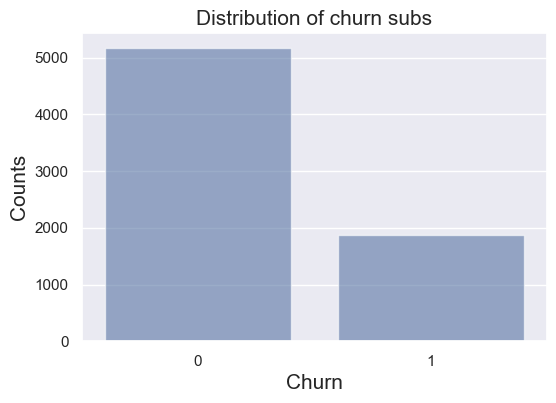

In [13]:
plt.figure(figsize=(6,4))
churn_cnt = clean_df.Churn.value_counts()
sns.barplot(x=churn_cnt.index, y=churn_cnt.values, alpha=0.6)
plt.xlabel("Churn",fontsize=15)
plt.ylabel("Counts",fontsize=15)
plt.title("Distribution of churn subs",fontsize=15)

In [16]:
# Upsampling using resample
x_train_us, y_train_us = resample(
    x_train[y_train == 1],
    y_train[y_train == 1],
    replace=True,
    n_samples=x_train[y_train == 0].shape[0],
    random_state=1
)

x_train_us = pd.concat([x_train_us, x_train[y_train == 0]], axis=0)
y_train_us = pd.concat([y_train_us, y_train[y_train == 0]], axis=0)

# Upsampling using SMOTE (updated with sampling_strategy)
sm = SMOTE(random_state=12, sampling_strategy=1.0)
x_train_sm, y_train_sm = sm.fit_resample(x_train, y_train)

# Downsampling using resample
x_train_ds, y_train_ds = resample(
    x_train[y_train == 0],
    y_train[y_train == 0],
    replace=True,
    n_samples=x_train[y_train == 1].shape[0],
    random_state=1
)

x_train_ds = pd.concat([x_train_ds, x_train[y_train == 1]], axis=0)
y_train_ds = pd.concat([y_train_ds, y_train[y_train == 1]], axis=0)

# Printing shapes
print("original shape:", x_train.shape)
print("Upsampling using resample:", x_train_us.shape)
print("Upsampling using SMOTE:", x_train_sm.shape)
print("Downsampling using resample:", x_train_ds.shape)

original shape: (5634, 26)
Upsampling using resample: (8266, 26)
Upsampling using SMOTE: (8266, 26)
Downsampling using resample: (3002, 26)


In [19]:
samples = {'original': (x_train, y_train)
          , 'Upsampled': (x_train_us, y_train_us)
          , 'SMOTE': (x_train_sm, y_train_sm)
          , 'Downsampled': (x_train_ds, y_train_ds)}

for sample in samples:
    scores = cross_val_score(LogisticRegression(),samples[sample][0], samples[sample][1], cv=5 , scoring = 'f1')
    print(sample, " : ", scores.mean())
    
    
scores = cross_val_score(LogisticRegression(class_weight='balanced'),x_train, y_train, cv=5 , scoring = 'f1')
print("Original data with balanced characteristic in logistic model  : ", scores.mean())

original  :  0.5663150707443811
Upsampled  :  0.7584606235776793
SMOTE  :  0.7970004871700956
Downsampled  :  0.760186907615281
Original data with balanced characteristic in logistic model  :  0.6148728252678956


In [25]:
lg_model = LogisticRegression(class_weight='balanced',random_state=42)
lg_model.fit(x_train_sm,y_train_sm)

LogisticRegression(class_weight='balanced', random_state=42)

In [29]:
print("Hard predict: \n", lg_model.predict(x_test)[:10])

Hard predict: 
 [0 0 1 0 1 1 0 1 0 1]


In [32]:
print("Soft predict: \n", lg_model.predict_proba(x_test)[:10])

Soft predict: 
 [[0.67591027 0.32408973]
 [0.90320415 0.09679585]
 [0.36397495 0.63602505]
 [0.94330967 0.05669033]
 [0.38257295 0.61742705]
 [0.11620131 0.88379869]
 [0.97393463 0.02606537]
 [0.1565231  0.8434769 ]
 [0.95756596 0.04243404]
 [0.48414036 0.51585964]]


In [35]:
lg_predicted = lg_model.predict(x_test)

# Confusion matrix
metrics.confusion_matrix(y_test,lg_predicted)

## TN , FP 
## FN , TP

array([[779, 262],
       [102, 266]])

In [40]:
# Classification report

print(metrics.classification_report(y_test,lg_predicted))

              precision    recall  f1-score   support

           0       0.88      0.75      0.81      1041
           1       0.50      0.72      0.59       368

    accuracy                           0.74      1409
   macro avg       0.69      0.74      0.70      1409
weighted avg       0.78      0.74      0.75      1409



In [43]:
print("ROC AUC score: ",metrics.roc_auc_score(y_test, lg_predicted))

ROC AUC score:  0.7355725055339766


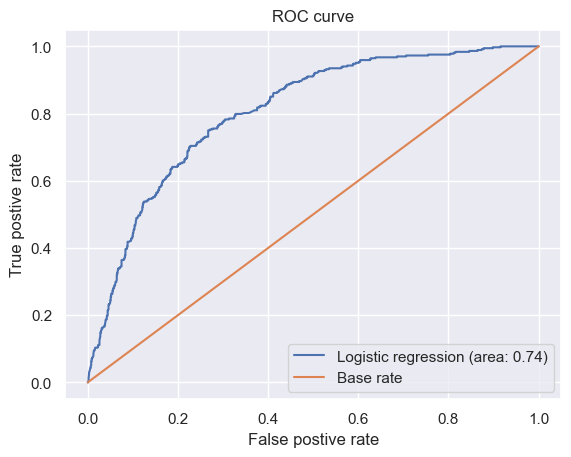

In [46]:
# ROC curve

fpr, tpr, thresold = metrics.roc_curve(y_test, lg_model.predict_proba(x_test)[:][:,1])

plt.plot(fpr,tpr , label = 'Logistic regression (area: %0.2f)' % metrics.roc_auc_score(y_test, lg_predicted))
plt.plot([0,1],[0,1],label = 'Base rate')
plt.xlabel("False postive rate")
plt.ylabel("True postive rate")
plt.title("ROC curve")
plt.legend()

In [49]:
rf_result_1 = cross_val_score(LogisticRegression(), x_train_sm, y_train_sm ,cv=5, scoring = 'accuracy')
print(rf_result_1.mean())

0.7922870805416995


##Random Forest

In [53]:
RF_model = RandomForestClassifier(oob_score = True, random_state = 42)

In [57]:
RF_model.fit(x_train,y_train)

print("OOB score", RF_model.oob_score_)

OOB score 0.7507987220447284


In [60]:
rf_result = cross_val_score(RF_model, x_train, y_train, scoring = 'accuracy')
print(rf_result.mean())

0.7493789607896598


In [63]:
predicted = np.argmax(RF_model.oob_decision_function_, axis = 1)
metrics.roc_auc_score(y_train, predicted)

np.float64(0.6570464435920049)

In [66]:
smote = SMOTE(random_state=42, sampling_strategy=1.0)
x_train_sm, y_train_sm = smote.fit_resample(x_train, y_train)

In [69]:
RF_model_1 = RandomForestClassifier(oob_score = True, random_state = 42)

In [72]:
RF_model_1.fit(x_train_sm, y_train_sm)

print("OOB score", RF_model_1.oob_score_)

OOB score 0.825066537624002


In [75]:
rf_result_1 = cross_val_score(RF_model_1, x_train_sm, y_train_sm, scoring = 'accuracy')
print(rf_result_1.mean())

0.8216870722024592


In [77]:
predicted_1 = np.argmax(RF_model_1.oob_decision_function_, axis = 1)
metrics.roc_auc_score(y_train, predicted)

np.float64(0.6570464435920049)

Max depth size 1
Train AUC ROC score  0.7493346237599806
Test AUC ROC score  0.722114762143424
Max depth size 2
Train AUC ROC score  0.7579240261311396
Test AUC ROC score  0.7284540366704255
Max depth size 3
Train AUC ROC score  0.7604645535930317
Test AUC ROC score  0.7348624859040221
Max depth size 4
Train AUC ROC score  0.7682071134768933
Test AUC ROC score  0.7331187612245751
Max depth size 5
Train AUC ROC score  0.7775223808371642
Test AUC ROC score  0.7377704339472915
Max depth size 7
Train AUC ROC score  0.7994193080087104
Test AUC ROC score  0.7412278640938896
Max depth size 10
Train AUC ROC score  0.8510766997338495
Test AUC ROC score  0.730068548218686
Max depth size 15
Train AUC ROC score  0.9251149286232762
Test AUC ROC score  0.7006014283924321
Max depth size 20
Train AUC ROC score  0.9292281635615776
Test AUC ROC score  0.6913372384412981


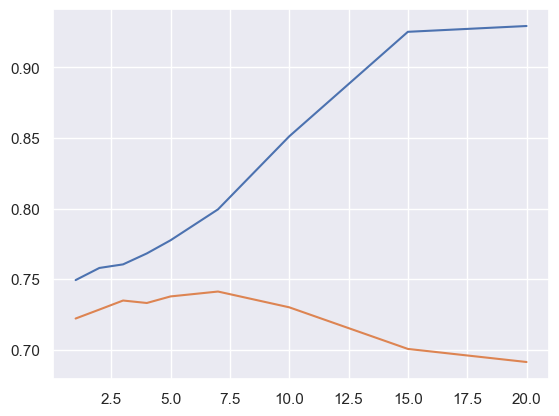

In [80]:
# MAx Depth size
max_depth_size = [1,2,3,4,5,7,10,15,20]
train_roc_score = []
test_roc_score = []

for depth in max_depth_size:
    model = RandomForestClassifier(oob_score = True, random_state = 42, max_depth = depth)
    model.fit(x_train_sm, y_train_sm)
    train_pred = model.predict(x_train_sm)
    test_pred = model.predict(x_test)
    roc_auc_train = metrics.roc_auc_score(y_train_sm, train_pred)
    roc_auc_test = metrics.roc_auc_score(y_test, test_pred)
    train_roc_score.append(roc_auc_train)
    test_roc_score.append(roc_auc_test)
    print("Max depth size", depth)
    print("Train AUC ROC score ", roc_auc_train)
    print("Test AUC ROC score ", roc_auc_test)


plt.plot(max_depth_size, train_roc_score)
plt.plot(max_depth_size, test_roc_score)

C:\Users\hajar\bootcamp-files\week_8\Project_Customer_churn_analysis\churn_proj\Lib\site-packages\sklearn\ensemble\_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
C:\Users\hajar\bootcamp-files\week_8\Project_Customer_churn_analysis\churn_proj\Lib\site-packages\sklearn\ensemble\_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
C:\Users\hajar\bootcamp-files\week_8\Project_Customer_churn_analysis\churn_proj\Lib\site-packages\sklearn\ensemble\_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
C:\Users\hajar\bootcamp-files\week_8\Project_Customer_churn_analysis\churn_proj\Lib\site-packages\sklearn\ensemble\_forest.py:615: UserWarning: Some inputs do not have OOB scores. This pr

No of trees 1
Train AUC ROC Score 0.7686910234696346
Test AUC ROC Score 0.7249796391429646
No of trees 5
Train AUC ROC Score 0.7747398983789016
Test AUC ROC Score 0.7215222089963662
No of trees 10
Train AUC ROC Score 0.7786111783208325
Test AUC ROC Score 0.7173638955018168
No of trees 20
Train AUC ROC Score 0.7818775707718365
Test AUC ROC Score 0.7277792569853402
No of trees 50
Train AUC ROC Score 0.7772804258407937
Test AUC ROC Score 0.7378526604853193
No of trees 70
Train AUC ROC Score 0.777764335833535
Test AUC ROC Score 0.7364939648331454
No of trees 100
Train AUC ROC Score 0.7775223808371642
Test AUC ROC Score 0.7377704339472915
No of trees 150
Train AUC ROC Score 0.7771594483426082
Test AUC ROC Score 0.7348885895668881
No of trees 200
Train AUC ROC Score 0.7769174933462375
Test AUC ROC Score 0.7344905087081819
No of trees 500
Train AUC ROC Score 0.7760706508589402
Test AUC ROC Score 0.734010201311448
No of trees 1000
Train AUC ROC Score 0.7761916283571257
Test AUC ROC Score 0.732

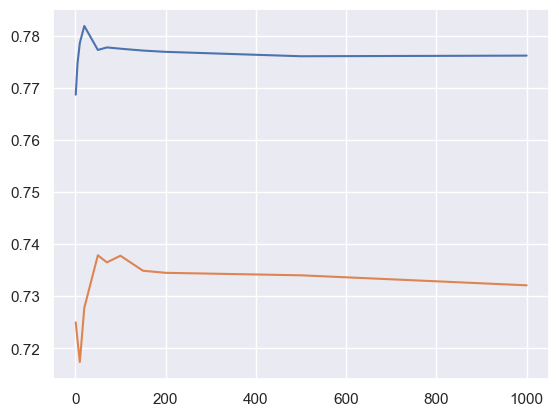

In [82]:
n_estimator_size = [1,5,10,20,50,70,100,150,200,500,1000]
train_roc_score = []
test_roc_score = []


for estimator in n_estimator_size:
    model = RandomForestClassifier(estimator, random_state = 42, oob_score = True, max_depth = 5)
    model.fit(x_train_sm, y_train_sm)
    train_pred = model.predict(x_train_sm)
    test_pred = model.predict(x_test)
    roc_auc_train = metrics.roc_auc_score(y_train_sm, train_pred)
    roc_auc_test = metrics.roc_auc_score(y_test, test_pred)
    train_roc_score.append(roc_auc_train)
    test_roc_score.append(roc_auc_test)
    print("No of trees", estimator)
    print("Train AUC ROC Score", roc_auc_train)
    print("Test AUC ROC Score", roc_auc_test)

plt.plot(n_estimator_size, train_roc_score)
plt.plot(n_estimator_size, test_roc_score)

In [84]:
max_features = ['sqrt','log2',0.7,0.2]
oob_score = []

for feature in max_features:
    model = RandomForestClassifier( n_estimators = 200, oob_score = True, random_state = 42 ,  max_depth = 5, max_features = feature)
    model.fit(x_train_sm, y_train_sm)
    oob_score.append(model.oob_score_)
    print("Max features", feature)
    print("OOB Score", model.oob_score_)

Max features sqrt
OOB Score 0.7723203484151948
Max features log2
OOB Score 0.7701427534478587
Max features 0.7
OOB Score 0.7818775707718364
Max features 0.2
OOB Score 0.7723203484151948


min_samples_leaf: 1
OOB Score: 0.7723203484151948
min_samples_leaf: 2
OOB Score: 0.7720783934188241
min_samples_leaf: 3
OOB Score: 0.7723203484151948
min_samples_leaf: 4
OOB Score: 0.7725623034115654
min_samples_leaf: 5
OOB Score: 0.7724413259133801
min_samples_leaf: 10
OOB Score: 0.7696588434551174
min_samples_leaf: 15
OOB Score: 0.7712315509315267
min_samples_leaf: 20
OOB Score: 0.7700217759496734
min_samples_leaf: 50
OOB Score: 0.769174933462376


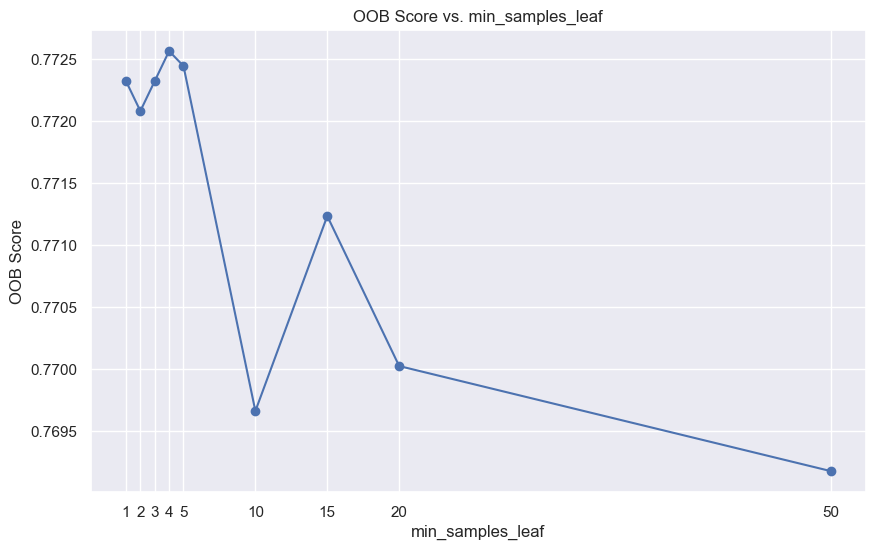

In [86]:
# Min sample leaf 
min_samples_leaf = [1, 2, 3, 4, 5, 10, 15, 20, 50]
oob_scores = []

for sample in min_samples_leaf:
    model = RandomForestClassifier(n_estimators=200, oob_score=True, random_state=42, max_depth=5, min_samples_leaf=sample, max_features='sqrt')
    model.fit(x_train_sm, y_train_sm)
    oob_scores.append(model.oob_score_)
    print("min_samples_leaf:", sample)
    print("OOB Score:", model.oob_score_)

plt.figure(figsize=(10, 6))
plt.plot(min_samples_leaf, oob_scores, marker='o')
plt.title('OOB Score vs. min_samples_leaf')
plt.xlabel('min_samples_leaf')
plt.ylabel('OOB Score')
plt.xticks(min_samples_leaf)
plt.grid(True)
plt.show()

In [88]:
RF_model_final = RandomForestClassifier(n_estimators = 5, random_state = 42, max_depth = 5)
RF_model_final.fit(x_train_sm,y_train_sm)

RandomForestClassifier(max_depth=5, n_estimators=5, random_state=42)

In [94]:
RF_model_final.estimators_

[DecisionTreeClassifier(max_depth=5, max_features='sqrt',
                        random_state=1608637542),
 DecisionTreeClassifier(max_depth=5, max_features='sqrt',
                        random_state=1273642419),
 DecisionTreeClassifier(max_depth=5, max_features='sqrt',
                        random_state=1935803228),
 DecisionTreeClassifier(max_depth=5, max_features='sqrt', random_state=787846414),
 DecisionTreeClassifier(max_depth=5, max_features='sqrt', random_state=996406378)]

In [97]:
# Confusion matrix
predicted = RF_model_final.predict(x_test)
metrics.confusion_matrix(y_test,predicted)

array([[696, 345],
       [ 83, 285]])

In [100]:
# Classification report

print(metrics.classification_report(y_test,predicted))

              precision    recall  f1-score   support

           0       0.89      0.67      0.76      1041
           1       0.45      0.77      0.57       368

    accuracy                           0.70      1409
   macro avg       0.67      0.72      0.67      1409
weighted avg       0.78      0.70      0.71      1409



In [103]:
metrics.roc_auc_score(y_test,predicted)

np.float64(0.7215222089963662)

<Axes: >

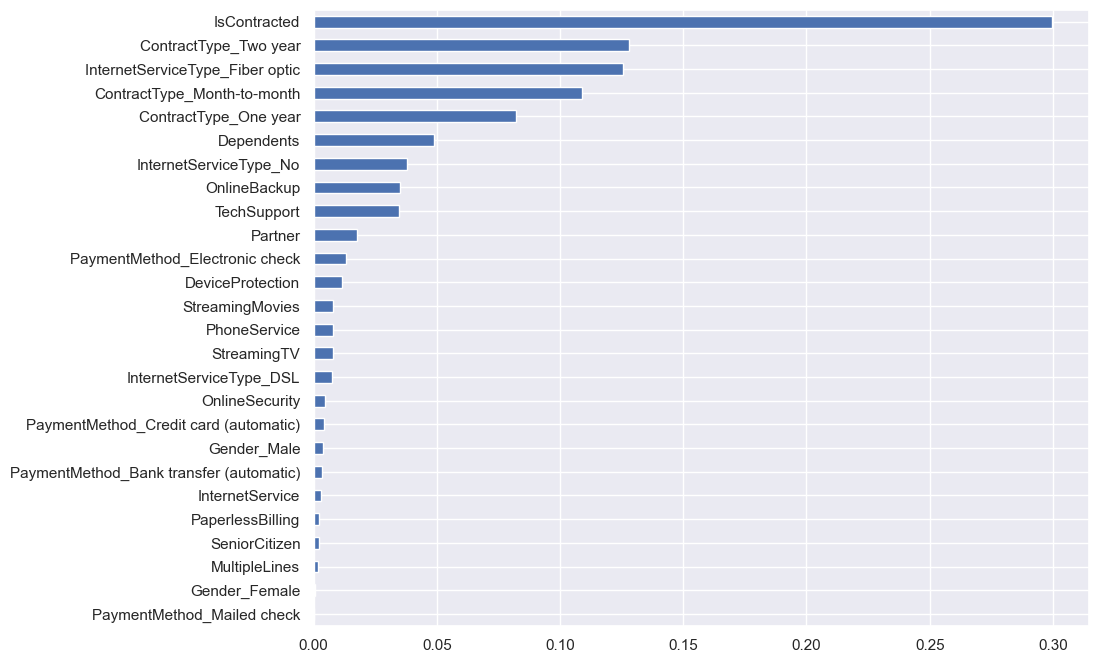

In [106]:
feature_importances = pd.Series(RF_model_final.feature_importances_,index = x_train.columns)
plt.figure(figsize=(10,8))
feature_importances.sort_values().plot(kind='barh')

In [109]:
selected_features = clean_df[['PaymentMethod','ContractType','InternetServiceType','OnlineSecurity','Churn']].copy()
selected_features['Payment_Electronic_Check'] = clean_df.PaymentMethod.map({'Electronic check':1,'Credit card (automatic)':0
                                                                            ,'Bank transfer (automatic)':0,'Mailed check':0 })
selected_features['Internet_Fiber_Optic'] = clean_df.InternetServiceType.map({'Fiber optic':1,'DSL':0
                                                                            ,'No':0})
selected_features.head()

,PaymentMethod,ContractType,InternetServiceType,OnlineSecurity,Churn,Payment_Electronic_Check,Internet_Fiber_Optic
0,Electronic check,Month-to-month,DSL,0,0,1,0
1,Mailed check,One year,DSL,1,0,0,0
2,Mailed check,Month-to-month,DSL,1,1,0,0
3,Bank transfer (automatic),One year,DSL,1,0,0,0
4,Electronic check,Month-to-month,Fiber optic,0,1,1,1


In [128]:
selected_feature_df = merge_df(one_hot_encoding_features_df(selected_features,['ContractType']),selected_features[['Payment_Electronic_Check','Internet_Fiber_Optic','OnlineSecurity']])
selected_target_df = clean_df[target_var]

In [130]:
feat_x_train, feat_x_test, feat_y_train, feat_y_test = train_test_split_fn(selected_feature_df, selected_target_df, test_size=0.2, random_state=42)

smote = SMOTE(random_state=42, sampling_strategy=1.0) 
feat_x_train_sm, feat_y_train_sm = smote.fit_resample(feat_x_train, feat_y_train)

In [134]:
RF_model_final = RandomForestClassifier(n_estimators = 1000, random_state = 42, max_depth = 7,class_weight = 'balanced')
RF_model_final.fit(feat_x_train,feat_y_train)

RandomForestClassifier(class_weight='balanced', max_depth=7, n_estimators=1000,
                       random_state=42)

In [136]:
predicted = RF_model_final.predict(feat_x_test)

In [139]:
# Confusion matrix
metrics.confusion_matrix(feat_y_test,predicted)

array([[771, 265],
       [ 96, 277]])

In [143]:
# Classification report

print(metrics.classification_report(feat_y_test,predicted))

              precision    recall  f1-score   support

           0       0.89      0.74      0.81      1036
           1       0.51      0.74      0.61       373

    accuracy                           0.74      1409
   macro avg       0.70      0.74      0.71      1409
weighted avg       0.79      0.74      0.76      1409



In [146]:
metrics.roc_auc_score(feat_y_test,predicted)

np.float64(0.7434179200264992)

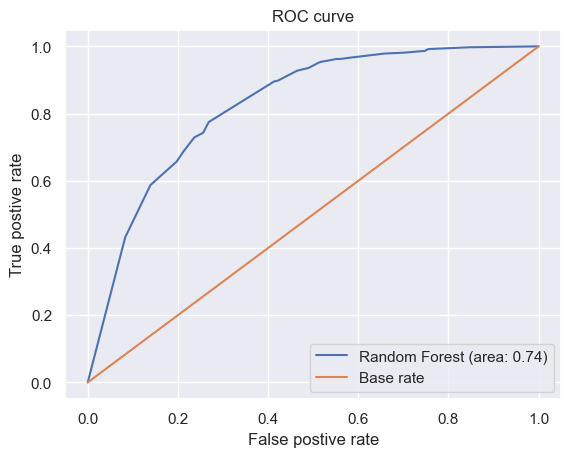

In [149]:
# ROC curve

fpr, tpr, thresold = metrics.roc_curve(feat_y_test, RF_model_final.predict_proba(feat_x_test)[:][:,1])

plt.plot(fpr,tpr , label = 'Random Forest (area: %0.2f)' % metrics.roc_auc_score(feat_y_test,predicted))
plt.plot([0,1],[0,1],label = 'Base rate')
plt.xlabel("False postive rate")
plt.ylabel("True postive rate")
plt.title("ROC curve")
plt.legend()

In [ ]:
# Random forest

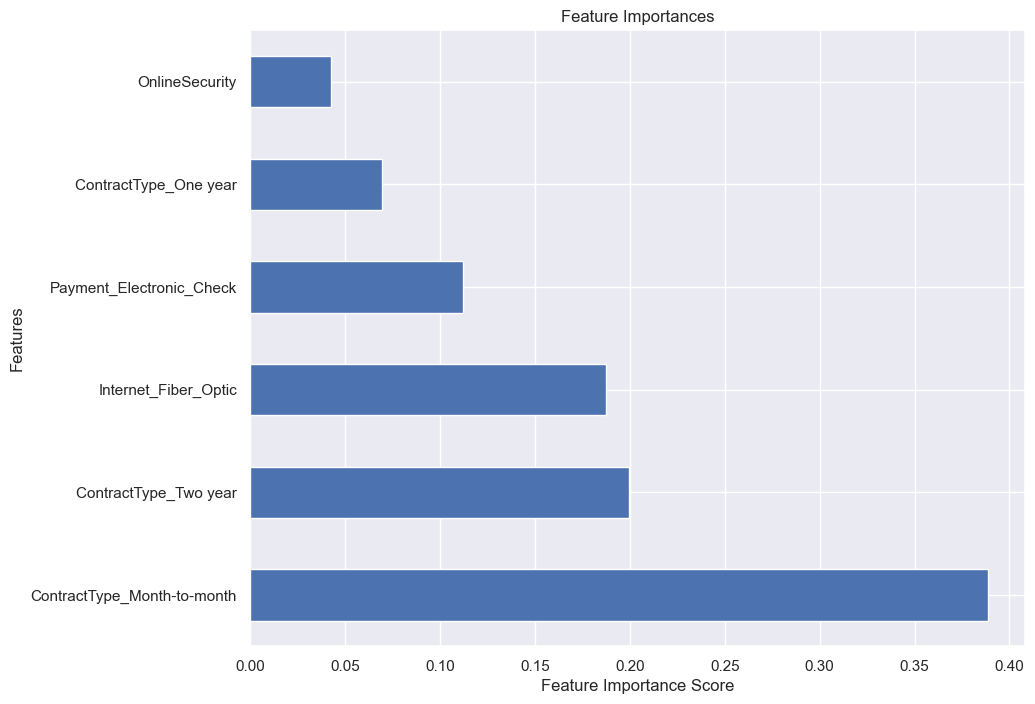

Confusion Matrix:
[[771 265]
 [ 96 277]]
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.74      0.81      1036
           1       0.51      0.74      0.61       373

    accuracy                           0.74      1409
   macro avg       0.70      0.74      0.71      1409
weighted avg       0.79      0.74      0.76      1409

ROC AUC Score: 0.7434179200264992


In [152]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
import matplotlib.pyplot as plt
import pandas as pd

# Plot feature importances
feature_importances = pd.Series(RF_model_final.feature_importances_, index=feat_x_train.columns)
feature_importances = feature_importances.sort_values(ascending=False)

plt.figure(figsize=(10, 8))
feature_importances.plot(kind='barh')
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title('Feature Importances')
plt.show()

# Predict on test set
predicted = RF_model_final.predict(feat_x_test)

# Confusion matrix
cm = confusion_matrix(feat_y_test, predicted)
print("Confusion Matrix:")
print(cm)

# Classification report
cr = classification_report(feat_y_test, predicted)
print("Classification Report:")
print(cr)

# ROC AUC score
roc_auc = roc_auc_score(feat_y_test, predicted)
print(f"ROC AUC Score: {roc_auc}")

In [163]:
#GRADIENT BOOSTER :Retention plan

In [158]:
feature_df.head()

,Gender_Female,Gender_Male,InternetServiceType_DSL,InternetServiceType_Fiber optic,InternetServiceType_No,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,ContractType_Month-to-month,...,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,PaperlessBilling,InternetService,IsContracted
0,True,False,True,False,False,False,False,True,False,True,...,0,0,1,0,0,0,0,1,1,0
1,False,True,True,False,False,False,False,False,True,False,...,0,1,0,1,0,0,0,0,1,1
2,False,True,True,False,False,False,False,False,True,True,...,0,1,1,0,0,0,0,1,1,0
3,False,True,True,False,False,True,False,False,False,False,...,0,1,0,1,1,0,0,0,1,1
4,True,False,False,True,False,False,False,True,False,True,...,0,0,0,0,0,0,0,1,1,0


In [161]:
feature_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 26 columns):
 #   Column                                   Non-Null Count  Dtype
---  ------                                   --------------  -----
 0   Gender_Female                            7043 non-null   bool 
 1   Gender_Male                              7043 non-null   bool 
 2   InternetServiceType_DSL                  7043 non-null   bool 
 3   InternetServiceType_Fiber optic          7043 non-null   bool 
 4   InternetServiceType_No                   7043 non-null   bool 
 5   PaymentMethod_Bank transfer (automatic)  7043 non-null   bool 
 6   PaymentMethod_Credit card (automatic)    7043 non-null   bool 
 7   PaymentMethod_Electronic check           7043 non-null   bool 
 8   PaymentMethod_Mailed check               7043 non-null   bool 
 9   ContractType_Month-to-month              7043 non-null   bool 
 10  ContractType_One year                    7043 non-null   bool 
 11  Cont

In [169]:
key_selected_features = ['ContractType_Month-to-month', 'ContractType_Two year', 'InternetServiceType_Fiber optic', 'PaymentMethod_Electronic check', 'ContractType_One year', 'OnlineSecurity' ]
key_features = feature_df[key_selected_features].copy()

In [172]:
key_features.head()

,ContractType_Month-to-month,ContractType_Two year,InternetServiceType_Fiber optic,PaymentMethod_Electronic check,ContractType_One year,OnlineSecurity
0,True,False,False,True,False,0
1,False,False,False,False,True,1
2,True,False,False,False,False,1
3,False,False,False,False,True,1
4,True,False,True,True,False,0


In [175]:
# Select the relevant features and target variable
X = key_features
y = target_df

In [178]:
# Train-Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

# Standardize the numeric features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [181]:
X_train_scaled

array([[ 0.90087489, -0.56245457,  1.12044827,  1.39854519, -0.51195388,
        -0.63170909],
       [ 0.90087489, -0.56245457, -0.89249993,  1.39854519, -0.51195388,
        -0.63170909],
       [-1.11003205,  1.77792138, -0.89249993, -0.71502874, -0.51195388,
         1.58300715],
       ...,
       [ 0.90087489, -0.56245457,  1.12044827,  1.39854519, -0.51195388,
        -0.63170909],
       [-1.11003205, -0.56245457, -0.89249993, -0.71502874,  1.95330095,
         1.58300715],
       [ 0.90087489, -0.56245457, -0.89249993, -0.71502874, -0.51195388,
        -0.63170909]])

In [184]:
# Train the logistic regression model
model = LogisticRegression()
model.fit(X_train_scaled, y_train)

LogisticRegression()

In [187]:
# Use the model to predict probabilities for existing customers (including train and test sets)
probabilities = model.predict_proba(scaler.transform(X))[:, 1]

In [190]:
# Categorize the churn risk
risk_category = pd.cut(probabilities, bins=[0, 0.3, 0.6, 1.0], labels=['Low', 'Medium', 'High'])

# Add the probabilities and risk category to the existing key_features DataFrame
key_features['churn_probability'] = probabilities
key_features['risk_category'] = risk_category

# Display the results
print(key_features[['ContractType_Month-to-month', 'ContractType_Two year', 'InternetServiceType_Fiber optic', 'PaymentMethod_Electronic check', 'ContractType_One year', 'OnlineSecurity', 'churn_probability', 'risk_category']])

      ContractType_Month-to-month  ContractType_Two year  \
0                            True                  False   
1                           False                  False   
2                            True                  False   
3                           False                  False   
4                            True                  False   
...                           ...                    ...   
7038                        False                  False   
7039                        False                  False   
7040                         True                  False   
7041                         True                  False   
7042                        False                   True   

      InternetServiceType_Fiber optic  PaymentMethod_Electronic check  \
0                               False                            True   
1                               False                           False   
2                               False                       

C:\Users\hajar\AppData\Local\Temp\ipykernel_16612\2425780872.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=risk_counts.index, y=risk_counts.values, palette=colors)


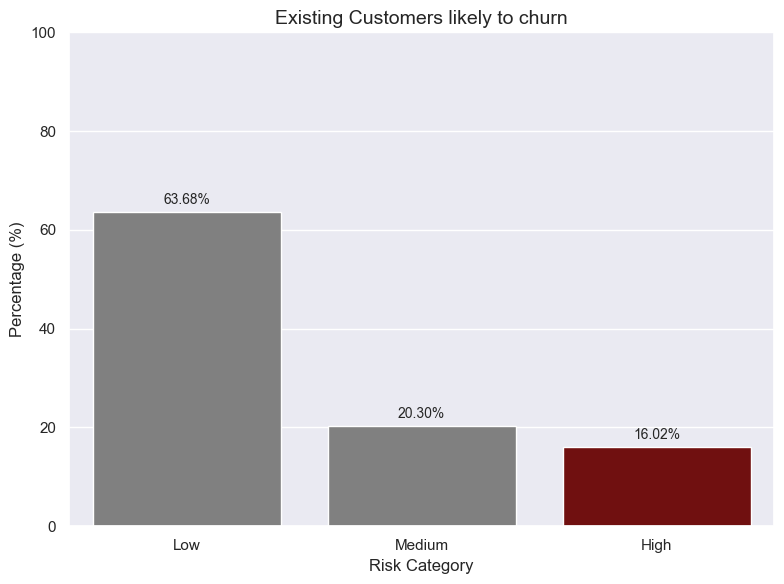

In [193]:
# Calculate percentage distribution of risk categories
risk_counts = key_features['risk_category'].value_counts(normalize=True) * 100

# Plotting
plt.figure(figsize=(8, 6))

# Custom colors for bars
colors = ['grey' if cat in ['Low', 'Medium'] else 'maroon' for cat in risk_counts.index]

sns.barplot(x=risk_counts.index, y=risk_counts.values, palette=colors)

# Adding labels and title
plt.xlabel('Risk Category', fontsize=12)
plt.ylabel('Percentage (%)', fontsize=12)
plt.title('Existing Customers likely to churn', fontsize=14)

# Setting y-axis limits to 0-100%
plt.ylim(0, 100)

# Adding percentages on top of each bar
for index, value in enumerate(risk_counts):
    plt.text(index, value + 1, f'{value:.2f}%', ha='center', va='bottom', fontsize=10)
plt.tight_layout()
plt.show()